### Imports

In [1]:
# For Docker image tensorflow/tensorflow:2.14.0-gpu-juptyer
!pip install -q nltk

In [2]:
from typing import Union
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
import numpy as np
from numpy import ndarray
import tensorflow as tf

2024-04-13 01:53:59.796425: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# The device_name will be used in model.fit()
gpu_devices = tf.config.experimental.list_physical_devices("GPU")

if gpu_devices:
    print("GPU available, using GPU")
    tf.config.experimental.set_visible_devices(gpu_devices[0], "GPU")
    device_name = "/GPU:0"
else:
    print("GPU not available, using CPU")
    device_name = "/CPU:0"

GPU available, using GPU


2024-04-13 01:54:02.412469: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-13 01:54:02.469696: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-13 01:54:02.469742: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### Function for loading data set

In [4]:
def load_text_file(file_path: str) -> list[str]:
    """
    Load a text file and return an array of lines from the file.

    Args:
        file_path: str: The path to the file to load.

    Returns:
        list[str]: An array of lines from the file.
    """
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

### Load the text files

In [5]:
train_text_path: str = "../dataset/train_text.txt"
train_label_path: str = "../dataset/train_labels.txt"

test_text_path: str = "../dataset/test_text.txt"
test_label_path: str = "../dataset/test_labels.txt"

validationt_text_path: str = "../dataset/val_text.txt"
validationt_label_path: str = "../dataset/val_labels.txt"

train_text: list[str] = load_text_file(train_text_path)
train_label: list[str] = load_text_file(train_label_path)

test_text: list[str] = load_text_file(test_text_path)
test_label: list[str] = load_text_file(test_label_path)

validation_text: list[str] = load_text_file(validationt_text_path)
validation_label: list[str] = load_text_file(validationt_label_path)

### Preprocessing

#### Download the NLTK resources and declere global variables

In [6]:
# Set stopwords
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)
nltk.download("vader_lexicon", quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
stopwords = set(nltk.corpus.stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Declare a dict of emojis and their corresponding sentiment
# 0: Negative; 1: Neutral; 2: Positive
emoji_dict = {
    "😊": 2,
    "😂": 2,
    "😭": 0,
    "😍": 2,
    "😘": 2,
    "😁": 2,
    "😩": 0,
    "😏": 2,
    "😉": 2,
    "😎": 2,
    "😢": 0,
    "😅": 2,
    "😱": 0,
    "😆": 2,
    "😋": 2,
    "😷": 0,
    "😔": 0,
    "😒": 0,
    "😡": 0,
    "😪": 0,
    "😤": 0,
    "😝": 2,
    "😓": 0,
    "😖": 0,
    "😣": 0,
    "😞": 0,
    "😐": 1,
    "😕": 0,
    "😫": 0,
    "😨": 0,
    "😌": 2,
    "😜": 2,
    "😑": 1,
    "😬": 0,
    "😈": 0,
    "😯": 0,
    "😳": 0,
    "😇": 2,
    "😷": 0,
    "😴": 0,
    "😲": 0,
    "😵": 0,
    "😦": 0,
    "😢": 0,
    "😮": 0,
    "😟": 0,
    "😥": 0,
    "😧": 0,
    "😰": 0,
    "😓": 0,
    "😩": 0,
    "😿": 0,
    "😾": 0,
    "🙀": 0,
    "🙅": 0,
    "🙆": 0,
    "🙇": 0,
    "🙈": 0,
    "🙉": 0,
    "🙊": 0,
    "🙋": 0,
    "🙌": 0,
    "🙍": 0,
    "🙎": 0,
    "🙏": 0,
    ":)": 2,
    ":(": 0,
    "❤️": 2,
    "👍": 2,
    "✌🏼️": 2,
    "☹️": 0,
    "🙃": 0,
    "👎": 0,
    "💙": 2,
    "💗": 2,
    "🎉": 2,
    "😄": 2,
    "🤗": 2,
    ":D": 2,
    "🎄": 2,
    "🎁": 2,
    ":/": 0,
    "?!": 0,
    ":P": 2,
    ":p": 2,
}

### Functions for preprocessing

In [7]:
def text_processing(text: list[str]) -> list[list[str]]:
    """
    Process text data:
    - Remove '@user'
    - Remove hashtags
    - Remove '-'
    - Remove URLs
    - Replace emojis with their corresponding sentiment.
    - Replace punctuation marks.
    - Tokenize the text.
    - Normalize the text with nltk.
    - Lowercase the text.
    - Remove numbers.
    # Length of the line is added after vectorization.

    Args:
        text: list[str]: A list of text data.

    Returns:
        list[list[str]]: A list of list of processed text data.
    """
    processed_text = []
    for line in text:
        # Remove '@user'
        line = line.replace("@user", " ")
        # Remove hashtags
        line = line.replace("#", " ")
        # Remove '-'
        line = line.replace("-", " ")
        # Remove URLs (http, https, www)
        line = " ".join([word for word in line.split() if "http" not in word])
        line = " ".join([word for word in line.split() if "www" not in word])
        # Replace emojis with their corresponding sentiment
        line = replace_emojis(line)
        # Replace punctuation marks
        line = punctuation_replacement(line)
        # Tokenize the text.
        tokens = nltk.word_tokenize(line)
        # Normalize the text using WordNetLemmatizer and tokenize the text
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        # Lowercase the text
        tokens = [str(word).lower() for word in tokens]
        processed_text.append(tokens)

    return processed_text


def vectorize_text(
    input: list[list[str]], vocabulary: list[str]
) -> ndarray[ndarray[float]]:
    """
    Vectorize the text data.

    Args:
        input: list[list[str]]: A list of list of text data (Full *_text).
        vocabulary: list[str]: The list of most common words.

    Returns:
        ndarray[ndarray[float]]: A numpy array of vectorized text data.
    """
    vectorized_text = np.zeros((len(input), len(vocabulary)))
    for i, line in enumerate(input):
        for word in line:
            if word in vocabulary:
                vectorized_text[i, vocabulary.index(word)] += 1
    return vectorized_text


def map_emoji_sentiment(input: int) -> str:
    """
    Map the emoji sentiment to a string.

    Args:
        input: int: The emoji sentiment.

    Returns:
        str: The string sentiment.
    """
    if input == 0:
        return " bad "
    elif input == 1:
        return " neutral "
    elif input == 2:
        return " good "
    else:
        return " neutral "


def replace_emojis(input: str) -> str:
    """
    Replace emojis with their corresponding sentiment.
    If the emoji is 0, replace it with 'bad'.
    If the emoji is 1, replace it with 'neutral'.
    If the emoji is 2, replace it with 'good'.
    If the emoji is not in the emoji_dict, replace it with 'neutral'.

    Args:
        input: str: The input text data (line).

    Returns:
        str: The text data with emojis replaced with their corresponding sentiment.
    """
    for emoji in emoji_dict:
        if emoji in input:
            input = input.replace(emoji, map_emoji_sentiment(emoji_dict[emoji]))
    return input


def get_sentiment_score(line: list[str]) -> list[float]:
    """
    Get the sentiment score of the input text data from SentimentIntensityAnalyzer.

    Args:
        line: list[str]: The input line.

    Returns:
        list[float]: The compound score of 10 words in the sentence which has
        the most significant score (far from 0). If the sentence has less than
        10 words, the value of the remaining elements will be 0.
        After that, the score for the whole line is added to the list.
    """
    scores: list[float] = []
    analyzer = SentimentIntensityAnalyzer()
    for string in line:
        score = analyzer.polarity_scores(string)["compound"]
        scores.append(score)
    line_score = analyzer.polarity_scores(" ".join(line))["compound"]

    # Get the 10 most significant scores and add the line score
    if len(scores) > 10:
        scores.sort(key=lambda x: abs(x), reverse=True)
        result = scores[:10]
        result.append(line_score)
    else:
        result = scores
        result += [0] * (10 - len(scores))
        result.append(line_score)

    return result


def learning_rate_scheduler(epoch: int) -> float:
    """
    Learning rate scheduler, to decrease the learning rate when epoch increases.

    Args:
        epoch: int: The current epoch.

    Returns:
        float: The new learning rate.
    """
    if epoch < 10:
        return 0.0005
    elif epoch < 20:
        return 0.0003
    else:
        return 0.0001


def punctuation_replacement(line: Union[str, list[str]]) -> str:
    """
    Check if there are repeated (>= 2) punctuation marks ['.' '!', '?'] in the line.
    If there are, no matter how many times the punctuation mark is repeated,
    replace it with ['MultiDot', 'MultiExclamation', 'MultiQuestion']
    respectively.

    Replace ['.' '!', '?'] with ['Dot', 'Exclamation', 'Question'] respectively.
    If they are not repeated in the line, keep them as they are.

    Args:
        line: Union[str, list[str]]: The input line, which can be a string or a list of words.

    Returns:
        str: The line with punctuation marks replaced.
    """
    # Split the line into words if it is a string
    if type(line) is str:
        line = line.split()
    # Replace punctuation marks
    for_append = []
    for i, word in enumerate(line):
        if word.count(".") >= 2:
            line[i] = line[i].replace(".", "")
            for_append.append("MultiDot")
        elif word.count("!") >= 2:
            line[i] = line[i].replace("!", "")
            for_append.append("MultiExclamation")
        elif word.count("?") >= 2:
            line[i] = line[i].replace("?", "")
            for_append.append("MultiQuestion")
        elif word.count(".") == 1:
            line[i] = line[i].replace(".", "")
            for_append.append("Dot")
        elif word.count("!") == 1:
            line[i] = line[i].replace("!", "")
            for_append.append("Exclamation")
        elif word.count("?") == 1:
            line[i] = line[i].replace("?", "")
            for_append.append("Question")

    line += for_append

    # Join back the line
    return " ".join(line)

### Process the text data

#### Process all text data

See function docstring from text_processing()

In [8]:
train_text: list[list[str]] = text_processing(train_text)
test_text: list[list[str]] = text_processing(test_text)
validation_text: list[list[str]] = text_processing(validation_text)

#### Get the length of each input line

Will be added as feature

In [9]:
train_text_len: list[int] = [len(line) for line in train_text]
test_text_len: list[int] = [len(line) for line in test_text]
validation_text_len: list[int] = [len(line) for line in validation_text]

#### Remove empty lines after processing

As there may exist lines with 0 words after removing words like stopwords

In [10]:
# Find index of lists in train_text and validation_text that are empty
empty_index_train: list[int] = [i for i, x in enumerate(train_text) if not x]

# Remove empty lists from train_text and validation_text, and corresponding labels
train_text: list[list[str]] = [
    train_text[i] for i in range(len(train_text)) if i not in empty_index_train
]
train_label: list[list[str]] = [
    train_label[i] for i in range(len(train_label)) if i not in empty_index_train
]

#### Find the most common words in the training data

Will be used for vectorizing the input

In [11]:
word_frequency: dict[str, int] = {}
for line in train_text:
    for word in line:
        if word in word_frequency:
            word_frequency[word] += 1
        else:
            word_frequency[word] = 1

vocabulary: list[str] = [
    word
    for word, _ in sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)[
        :10000
    ]
]

#### Get the sentiment score of the text data

Will be used as feature

In [12]:
train_sentiment_score: ndarray[ndarray[float]] = np.array(
    [get_sentiment_score(line) for line in train_text]
)
test_sentiment_score: ndarray[ndarray[float]] = np.array(
    [get_sentiment_score(line) for line in test_text]
)
validation_sentiment_score: ndarray[ndarray[float]] = np.array(
    [get_sentiment_score(line) for line in validation_text]
)

##### Convert the labels to integers

In [13]:
train_label: list[int] = [int(label) for label in train_label]
test_label: list[int] = [int(label) for label in test_label]
validation_label: list[int] = [int(label) for label in validation_label]

### Vectorize the input

In [14]:
# Vectorize the text data
train_vectorized: ndarray[ndarray[float]] = vectorize_text(train_text, vocabulary)
test_vectorized: ndarray[ndarray[float]] = vectorize_text(test_text, vocabulary)
validation_vectorized: ndarray[ndarray[float]] = vectorize_text(
    validation_text, vocabulary
)

#### Remove entries with all 0 vector

In [15]:
# Find the entries with all zeros in the vectorized data
zero_index_train: ndarray[int] = np.where(~train_vectorized.any(axis=1))[0]

print("Original training data size:", len(train_vectorized))

# Remove entries with all zeros in the vectorized data, and corresponding labels
train_vectorized: ndarray[ndarray[float]] = np.delete(
    train_vectorized, zero_index_train, axis=0
)
train_label: list[int] = [
    train_label[i] for i in range(len(train_label)) if i not in zero_index_train
]

# Remove entries with all zeros in the sentiment score data
train_sentiment_score: ndarray[ndarray[float]] = np.delete(
    train_sentiment_score, zero_index_train, axis=0
)

# Convert the list of text lengths to numpy array
train_text_len: ndarray[int] = np.array(train_text_len)

# Remove entries with all zeros in the text length data
train_text_len: ndarray[int] = np.delete(train_text_len, zero_index_train)

print("Processed training data size:", len(train_vectorized))

Original training data size: 45615
Processed training data size: 45614


#### Add remaining feature

In [16]:
# Add the length of the text data to the vectorized data
train_vectorized: ndarray[ndarray[float]] = np.column_stack((train_vectorized, train_text_len))
test_vectorized: ndarray[ndarray[float]] = np.column_stack((test_vectorized, test_text_len))
validation_vectorized: ndarray[ndarray[float]] = np.column_stack((validation_vectorized, validation_text_len))

# Add sentiment score to each entry in the vectorized data
train_vectorized: ndarray[ndarray[float]] = np.concatenate((train_vectorized, train_sentiment_score), axis=1)
test_vectorized: ndarray[ndarray[float]] = np.concatenate((test_vectorized, test_sentiment_score), axis=1)
validation_vectorized: ndarray[ndarray[float]] = np.concatenate(
    (validation_vectorized, validation_sentiment_score), axis=1
)

#### Convert labels to one-hot encoding

For fitting into the neural network and testing

In [17]:
train_label_one_hot: ndarray[ndarray[float]] = tf.one_hot(train_label, 3)
validation_label_one_hot: ndarray[ndarray[float]] = tf.one_hot(validation_label, 3)
test_label_one_hot: ndarray[ndarray[float]] = tf.one_hot(test_label, 3)

2024-04-13 01:58:26.737426: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-13 01:58:26.737502: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-13 01:58:26.737518: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-13 01:58:26.856614: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-13 01:58:26.856681: I external/local_xla/xla/stream_executor

#### Final shape of training data

In [18]:
print("Training data shape:", train_vectorized.shape)

Training data shape: (45614, 10012)


### NN

#### Setup the neural network

In [19]:
# Create an Input layer
input_layer = tf.keras.layers.Input(shape=(train_vectorized.shape[1],))

dropout_rate = 0.7
activation_function = "sigmoid"

#tf.random.set_seed(2024)

# Define the model
neural_network = tf.keras.models.Sequential(
    [
        input_layer,
        tf.keras.layers.Dense(2048, activation=activation_function),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(512, activation=activation_function),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(128, activation=activation_function),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(3, activation="softmax"),
    ]
)

# Define early stopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, mode="min", verbose=1
)

# Add parameters to Adam optimizer if needed
modified_adam = tf.keras.optimizers.Adam()

neural_network.compile(
    optimizer=modified_adam, loss="categorical_crossentropy", metrics=["accuracy"]
)

rate_scheduler = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)

#### Train the model

In [20]:
with tf.device(device_name):
    history = neural_network.fit(
        train_vectorized,
        train_label_one_hot,
        validation_data=(validation_vectorized, validation_label_one_hot),
        epochs=200,
        batch_size=512,
        callbacks=[early_stopping, rate_scheduler],
    )

2024-04-13 01:58:27.806600: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1826749472 exceeds 10% of free system memory.
2024-04-13 01:58:28.479258: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1826749472 exceeds 10% of free system memory.


Epoch 1/200


I0000 00:00:1712973509.721101   32596 service.cc:145] XLA service 0x7f97d400b480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712973509.721150   32596 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-04-13 01:58:29.744546: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-13 01:58:29.857778: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


 7/90 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3808 - loss: 1.5819

I0000 00:00:1712973513.455203   32596 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4027 - loss: 1.2637

I0000 00:00:1712973518.774841   32742 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_48', 252 bytes spill stores, 252 bytes spill loads

I0000 00:00:1712973519.068321   32735 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_48', 464 bytes spill stores, 412 bytes spill loads

I0000 00:00:1712973519.212468   32743 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_53', 456 bytes spill stores, 408 bytes spill loads

I0000 00:00:1712973521.413150   32832 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_53', 28 bytes spill stores, 28 bytes spill loads

I0000 00:00:1712973521.681669   32826 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_53', 28 bytes spill stores, 20 bytes spill loads

I0000 00:00:1712973521.779549   32

90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.4028 - loss: 1.2623 - val_accuracy: 0.4345 - val_loss: 1.0213 - learning_rate: 5.0000e-04
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4342 - loss: 1.0347 - val_accuracy: 0.4345 - val_loss: 1.0232 - learning_rate: 5.0000e-04
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4404 - loss: 1.0232 - val_accuracy: 0.4345 - val_loss: 1.0204 - learning_rate: 5.0000e-04
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4480 - loss: 1.0191 - val_accuracy: 0.4345 - val_loss: 1.0071 - learning_rate: 5.0000e-04
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4724 - loss: 1.0014 - val_accuracy: 0.5980 - val_loss: 0.9004 - learning_rate: 5.0000e-04
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5522 - loss: 0.9135 - val_accuracy: 0.6200 - val_loss: 0.7947 - learning_rate: 5.0000e-04
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6047 - l

#### Evaluate the model with test data

In [21]:
test_loss, test_accuracy = neural_network.evaluate(test_vectorized, test_label_one_hot)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

I0000 00:00:1712973551.897937   33692 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_48', 252 bytes spill stores, 252 bytes spill loads



363/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6422 - loss: 0.8256

I0000 00:00:1712973554.651136   33766 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_48', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1712973554.794571   33764 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_48', 512 bytes spill stores, 392 bytes spill loads



384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6419 - loss: 0.8263
Test loss: 0.8346948027610779
Test accuracy: 0.6377401351928711


#### Plot graphs about loss and accuracy during epochs

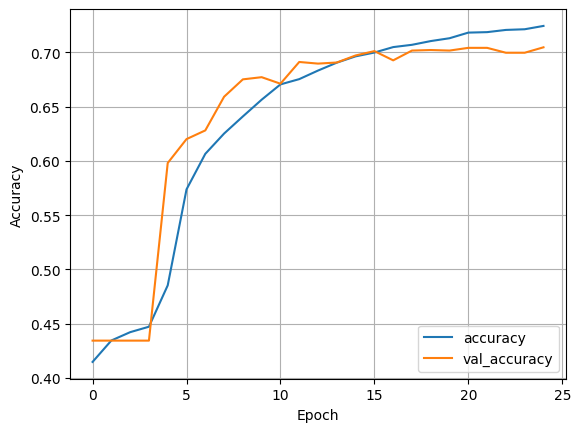

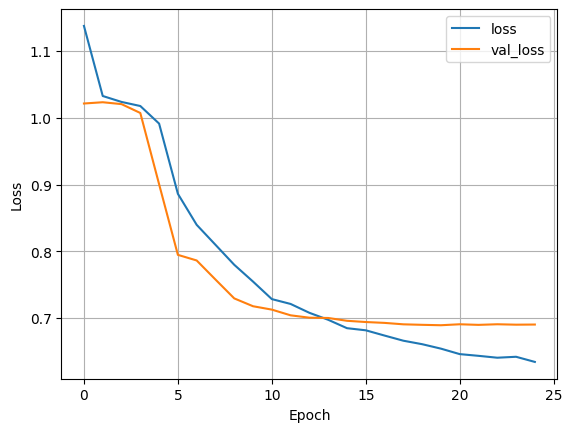

In [22]:
# Plot the training and validation accuracy
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Plot the training and validation loss
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid()
plt.show()

In [23]:
#neural_network.save('63_test.keras')

### For testing the model

Will be deleted before pushing to main

In [25]:
accuracy_list = []

for i in range(50):
    input_layer = tf.keras.layers.Input(shape=(train_vectorized.shape[1],))
    neural_network = tf.keras.models.Sequential(
        [
            input_layer,
            tf.keras.layers.Dense(2048, activation=activation_function),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(512, activation=activation_function),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(128, activation=activation_function),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(3, activation="softmax"),
        ]
    )
    neural_network.compile(
        optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"]
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, mode="min", verbose=1
    )
    with tf.device(device_name):
        history = neural_network.fit(
            train_vectorized,
            train_label_one_hot,
            validation_data=(validation_vectorized, validation_label_one_hot),
            epochs=200,
            batch_size=512,
            callbacks=[early_stopping, rate_scheduler],
        )
    test_loss, test_accuracy = neural_network.evaluate(test_vectorized, test_label_one_hot)
    print(i+1, test_accuracy)
    accuracy_list.append(test_accuracy)
    if test_accuracy >= 0.64:
        break

Epoch 1/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.4082 - loss: 1.1984 - val_accuracy: 0.4345 - val_loss: 1.0218 - learning_rate: 5.0000e-04
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4357 - loss: 1.0322 - val_accuracy: 0.4345 - val_loss: 1.0214 - learning_rate: 5.0000e-04
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4424 - loss: 1.0265 - val_accuracy: 0.4345 - val_loss: 1.0190 - learning_rate: 5.0000e-04
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4490 - loss: 1.0195 - val_accuracy: 0.4345 - val_loss: 1.0154 - learning_rate: 5.0000e-04
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4551 - loss: 1.0156 - val_accuracy: 0.5485 - val_loss: 0.9908 - learning_rate: 5.0000e-04
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5048 - loss: 0.9684 - val_accuracy: 0.6090 - val_loss: 0.8124 - learning_rate: 5.0000e-04
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 

In [26]:
print(accuracy_list)

[0.6374959349632263, 0.6382285952568054, 0.638065755367279, 0.6389612555503845, 0.6365190744400024, 0.6389612555503845, 0.6379843950271606, 0.6400195360183716]


In [27]:
#neural_network.save('64_test.keras')